In [19]:
import os
import h5py
import numpy as np

from ipywidgets import interact

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# configure matplotlib
mpl.style.use("classic")
import sys
sys.path.append("/users/pkeller/code/ClosurePhaseAnalysis/")

from library import cptools as cp
from library import dspec

In [38]:
# data path
path = "/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/EQ14_FC_B2.h5"

# polarisation ("XX"=0, "YY"=1)
pol =  0

if pol is 0:
    polname = "XX"
elif pol is 1:
    polname = "YY"
else:
    print("invalid polaisation number")

# load data
with h5py.File(path, "r") as f:
    jd = f["JD"][()]
    frq = f["FRQ"][()]
    lst = f["LST"][()]
    bispec1 = f["bispec med XX 1"][()]
    bispec2 = f["bispec med XX 2"][()]

In [8]:
def plot(j, tr):
    im = plt.imshow(
        np.flip(np.angle(bispec2[j, tr]), axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
        vmin=-np.pi,
        vmax=np.pi
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    plt.title(f"JD Bin{j}, Triad {tr}")
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, 3, 1), tr=(0, bispec2.shape[1]-1, 1))

interactive(children=(IntSlider(value=1, description='j', max=3), IntSlider(value=38, description='tr', max=76…

<function __main__.plot(j, tr)>

In [39]:
eicp1 = np.exp(1j*np.angle(bispec1[0]))
eicp2 = np.exp(1j*np.angle(bispec2[0]))
eicp_diff = eicp2 - eicp1
var = np.mean(np.abs(eicp_diff)**2, axis=-1)
print(var.shape)

(77, 752)


In [43]:
bispec1 = np.moveaxis(bispec1, -1, 0)
bispec = np.sum(bispec1 / var, axis=(1, 2)) / (var.sum(axis=0))
bispec = np.moveaxis(bispec, 0, -1)
bispec1 = np.moveaxis(bispec1, 0, -1)
print(bispec.shape)

(752, 161)


In [44]:
W = dspec.blackman_harris(bispec.shape[-1])
eicp = np.exp(1j * np.angle(bispec))
ft = dspec.fft(eicp, W=W, inverse=True, shift=True, axis=-1)
delay = dspec.delay(n=ft.shape[-1])
print(ft.shape)

(752, 161)


In [51]:
power = []

for n in range(1, ft.shape[0]-1):
    ft_avg = np.array([np.mean(ft[i: i+n], axis=0) for i in range(ft.shape[0]-n)])
    power.append(np.median(np.abs(ft_avg)**2, axis=0))

In [52]:
power = np.array(power)

In [53]:
power = power / power[0]

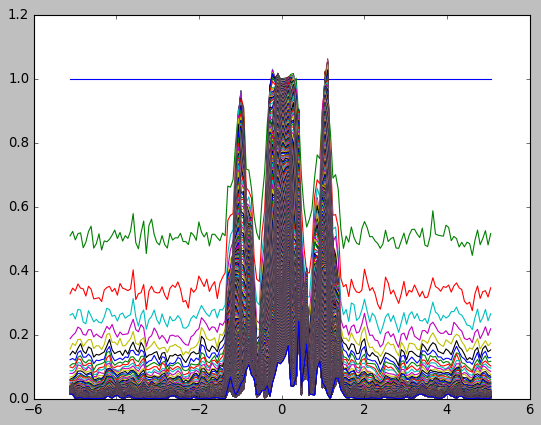

In [59]:
for n, p in enumerate(power):
    plt.plot(delay, p, label=f"{n}")


In [104]:
power = power.swapaxes(0, 1)

In [102]:
print(power.swapaxes(0, 1)[1])

[1.         0.52242735 0.345052   0.26600124 0.19734494 0.1727052
 0.14816977 0.12519814 0.1089307  0.09596473 0.0871432  0.07876469
 0.0693089  0.06425338 0.05774208 0.05760528 0.05433342 0.05084751
 0.04531362 0.04366287 0.0398202  0.03763651 0.03553487 0.03470669
 0.03412415 0.0340885  0.03282665 0.03174734 0.03257467 0.0321379
 0.0299558  0.03051016 0.02798853 0.02694654 0.02580908 0.02552198
 0.02436152 0.02282742 0.02200607 0.02205242 0.0209519  0.02143875
 0.02188052 0.02126217 0.02045988 0.02046827 0.02028712 0.0201855
 0.02037126 0.02074552 0.02096697 0.0216346  0.02125795 0.02045532
 0.02015037 0.01904721 0.01968399 0.01969772 0.01909521 0.01938754
 0.01971648 0.01995863 0.01846203 0.01881085 0.01848902 0.01822399
 0.01789206 0.01788941 0.01735848 0.01708799 0.01682403 0.01643321
 0.01604821 0.0159837  0.01543602 0.0157427  0.01534827 0.01480116
 0.01542776 0.01470254 0.01514436 0.01484958 0.01481478 0.01555014
 0.01590938 0.01549655 0.0157416  0.01557888 0.01572188 0.0156520

In [110]:
power = power.swapaxes(0, 1)
def plot(i):
    plt.plot(power[power.shape[0]//2+i], label=f"{n}")
    plt.xlim([0, 40])
    plt.ylim([0, 1.0])
    plt.show()
power = power.swapaxes(0, 1)
interact(plot, i=(-power.shape[0]//2, power.shape[0]//2))

interactive(children=(IntSlider(value=-1, description='i', max=80, min=-81), Output()), _dom_classes=('widget-…

<function __main__.plot(i)>

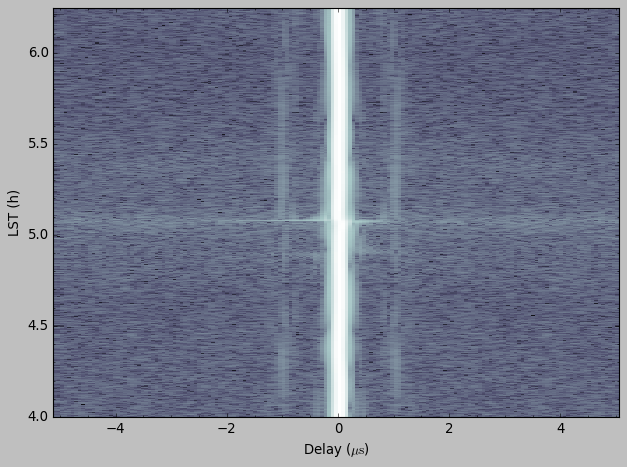

In [45]:
im = plt.imshow(
    np.flip(np.abs(ft)**2, axis=0),
    extent=(np.amin(delay), np.amax(delay), np.amin(lst), np.amax(lst)),
    cmap=cm.bone,
    interpolation="None",
    aspect="auto",    
    norm=mpl.colors.LogNorm()
)
    
plt.xlabel(r"Delay ($\mu\mathrm{s}$)")
plt.ylabel("LST (h)")
plt.ylim([min(lst), max(lst)])
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [8]:
bispec[flags] = np.nan
badjd = np.all(np.isnan(bispec), axis=(1, 2, 3))
badtr = np.all(np.isnan(bispec), axis=(0, 2, 3))
bispec = bispec[~badjd][:, ~badtr]
rfiflags = rfiflags[~badjd]
idx = np.where(rfiflags)
bispec[idx[0], :, idx[1], idx[2]] = np.nan
jd = jd[~badjd]

In [6]:
print(bispec.shape, rfiflags[0].shape)

(150, 95, 752, 161) (752, 161)


In [ ]:
# average in JD bins
bispec1 = np.array([cp.geomed(bispec[i::2], axis=0) for i in range(2)])
bispec2 = np.array([cp.geomed(bispec[i::4], axis=0) for i in range(4)])

In [56]:
nlst=20
bispec1 = np.array([np.nanmean(bispec1[:, :, i*nlst: (i+1)*nlst], axis=2)  for i in range(len(lst) // 20)])

In [59]:
bispec1 = np.moveaxis(bispec1, 1, 0)
bispec1 = np.array([bispec1, bispec1])

In [63]:
xps, err = cp.xps_matrix(np.angle(bispec1), np.zeros((bispec.shape[0], ) + (4,) + bispec1.shape[2:]), (max(frq)-min(frq))/2, 10.24)

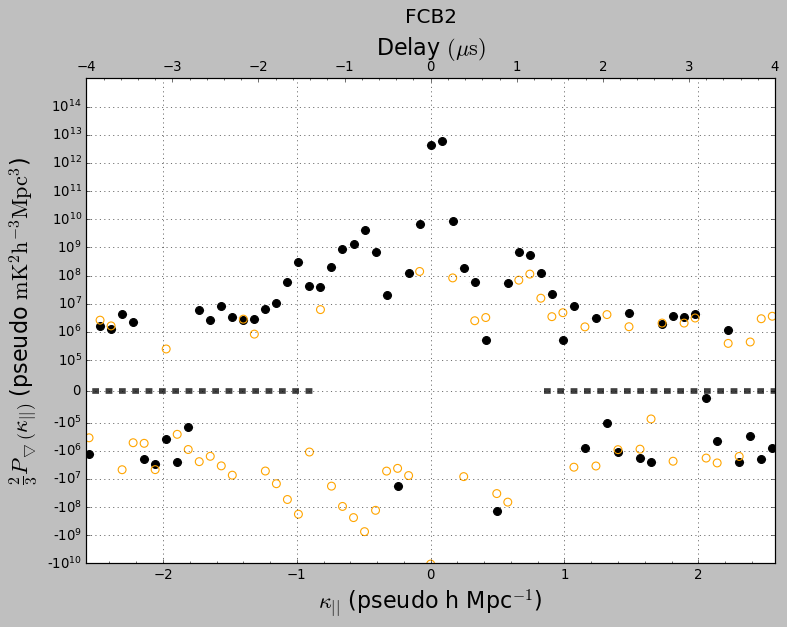

In [65]:
from library import dspec
fs=10.24
power = dspec.wavg(np.moveaxis(xps, 0, 2), offdiagonal=True)
error = np.mean(np.abs([dspec.wavg(np.moveaxis(err[i], 0, 2), offdiagonal=True) for i in range(err.shape[0])]), axis=0)
delay = dspec.delay(fs=fs, n=power.shape[-1])

dspec.power_plot(
    delay,
    power * 1e12, 
    error  * 1e12 / 2,
    linthresh=1e5,
    legend=False,
    onesided=False,
    title="FCB2",
)

In [29]:
bispec2 = np.moveaxis(bispec2, 0, 2)

In [41]:
clph2 = np.unwrap(np.angle(bispec2), axis=-1)


In [43]:
def plot(j, tr):
    im = plt.imshow(
        np.flip(clph2[j, tr]-clph2[j+1, tr], axis=0),
        extent=(np.amin(frq), np.amax(frq), np.amin(lst), np.amax(lst)),
        cmap=cm.twilight,
        interpolation="None",
        aspect="auto",
        vmin=-np.pi/2,
        vmax=np.pi/2
    )

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("LST (h)")
    plt.ylim([min(lst), max(lst)])
    plt.title(f"JD {jd[j]}, Triad {tr}")
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

interact(plot, j=(0, 3, 1), tr=(0, bispec2.shape[1], 1))

interactive(children=(IntSlider(value=1, description='j', max=3), IntSlider(value=38, description='tr', max=77…

<function __main__.plot(j, tr)>

In [ ]:
# average in lst
nlst = 20
bispec1 = np.array([np.nanmean(bispec1[:, :, i*nlst: (i+1)*nlst], axis=2)])
bispec2 = np.array([np.nanmean(bispec2[:, :, i*nlst: (i+1)*nlst], axis=2)])